# Final Project Baseline
Yang Wei Neo, Emily Rapport, Hilary Yamtich

## Load Libraries and Data

In [1]:
import pickle as pk

# Load the pickle file that contains the clean data and other useful stuff?
infile = open('./clean_data_pickle','rb')
data = pk.load(infile)
infile.close()

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import csv
from rfpimp import *
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# note: this notebook requires pandas 0.21.0 or newer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shared_functions as sf
import math
from datetime import datetime as dt
import re as re

# For producing decision tree diagrams.
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO

from dateutil import parser
import datetime

--------

# Run Baseline & Early Models

We started with a simple 15% dev set, but we have found that for this amount of data, the differences in the models and their scores on the dev sets can vary significantly based on which rows end up in the train and dev sets. Repeated random sub-sampling cross validation helps us get more consistent results.

Note that we do not split out the dev data using the most recent years, which would be the proper way to create a dev set if our task were explicitly to predict future home prices. The test data appears to have rows from all the years represented in the train set, so we built dev sets that sample from across the train set. 

In [3]:
# still to do : choose one version of pandas to use so that our code all agrees
# and I don't have to read in a new dataset here 
data['LogSalePrice'] = np.log(data['SalePrice'])
NUM_CROSS_VALS = 5

# get the list of different cross val splits
cross_val_list = []
for i in range(NUM_CROSS_VALS):
    split_idx = int(data.shape[0] * .85)
    # line below is what shuffles
    data = data.sample(frac=1)
    train_df = data[:split_idx]
    dev_df = data[split_idx:]
    split_dict = {'train_df': train_df,
                  'dev_df': dev_df}
    cross_val_list.append(split_dict)

As our primary error metric, we focus on the root mean squared error of the logarithm of the prices, which is the error metric being used to create the leaderboard for this kaggle competition. See rmsle() in shared_functions.py for our implementation of the root mean squared error, an implementation we found from Mark Nagelberg on Kaggle: https://www.kaggle.com/marknagelberg/rmsle-function.

When we consulted our resident real estate expert, Hilary's dad, about this problem, he told us that only one of these factors matters - "location, location, location." In the spirit of that insight, we created a baseline "model" which looks at what neighborhood the house is in and takes the mean price of houses from that neighborhood in the training set. 

In [4]:
# todo: figure out why i'm getting nans now
# when i wasn't in original notebook
def baseline_pred(row,
                  train_df):
    for col in train_df:
        if 'Neighborhood' in col:
            if row[col] == 1:
                neighborhood_var = col
                break
    return np.nanmean(train_df[train_df[neighborhood_var]==1]['LogSalePrice'])

def get_baseline_cross_val(cross_val_list):
    all_rmses = []
    for di in cross_val_list:
        dev_df = di['dev_df']
        dev_df['baseline_pred'] = dev_df.apply(lambda row: baseline_pred(row,
                                                                         di['train_df']), axis=1)
        rmse = sf.rmsle(list(np.exp(dev_df['LogSalePrice'])), list(np.exp(dev_df['baseline_pred'])))
        all_rmses.append(rmse)
    return np.nanmean(all_rmses) 

# baseline RMSLE
print("Baseline RMSLE: {:.3f}".format(get_baseline_cross_val(cross_val_list)))

Baseline RMSLE: 0.256


/Users/yangweineo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


With this as a baseline, we began exploring how different types of models perform on the problem.

#### Linear Regression

We begin with linear regression as the standard choice for a regression problem. In ordinary least squares regression, the regression line is fit by minimizing the sum of squared residuals between the predicted line and the true data points. We can interpret the resulting coefficients on each feature as representing the additional impact of a one-unit change in that feature on the final price.

In [96]:
pca_names = ['pca_' + str(i) for i in range(50)]

models_to_param_list = {LinearRegression: [{}], 
                        Lasso: [{'alpha': 0.5}], # lower value is less regularization
                        Ridge: [{'alpha': 2}], # more effective with more regularization
                        ElasticNet: [{'alpha': 0.001}]} # lower value is less regularization
outcome_vars = ['LogSalePrice']
feature_sets = [[col for col in data.columns if col not in ['YrMoSold', 'LogSalePrice', 'SalePrice', *pca_names]]]
#feature_sets = [pca_names]

lrdf = sf.try_different_models(cross_val_list, 
                               models_to_param_list,
                               outcome_vars, 
                               feature_sets)

lrdf.sort_values('Root MSE', ascending=True)

,Features,Model,Num Features,Outcome Var,Params,Root MSE,Train MSE
3,"[Id, MSSubClass, LotArea, OverallQual, Overall...","[ElasticNet(alpha=0.001, copy_X=True, fit_inte...",232,LogSalePrice,{'alpha': 0.001},0.140358,0.111193
2,"[Id, MSSubClass, LotArea, OverallQual, Overall...","[Ridge(alpha=2, copy_X=True, fit_intercept=Tru...",232,LogSalePrice,{'alpha': 2},0.140807,0.105536
0,"[Id, MSSubClass, LotArea, OverallQual, Overall...","[LinearRegression(copy_X=True, fit_intercept=T...",232,LogSalePrice,{},0.147538,0.098785
1,"[Id, MSSubClass, LotArea, OverallQual, Overall...","[Lasso(alpha=0.5, copy_X=True, fit_intercept=T...",232,LogSalePrice,{'alpha': 0.5},0.198478,0.181718


# YW SECTION 

### Linear Regression

- Will not work well with variables that are highly correlated with each other
- Indeed this is why linear regression with PCA seems to do just as well as the original variables; the  loss is not as great for linear regression (only 0.04 loss in RMSLE).

## Tree-based regressors

The family of tree-based regressors learns a series of simple decision rules to predict the final sale price. The decision tree regressor makes one single Decision Tree, whereas the Random Forest regressor trains an ensemble of decision trees.

### Bagging Illustration

Bagging, or bootstrap aggregation, is intended to reduce variance in the test error by averaging predictions over very specialized models. While each of these models in isolation is likely to overfit, the ensemble of specialized models ends up being very effective at reducing overall test error. To stress test this assumption, we run several random forest ensembles on models that are increasingly less likely to *individually* overfit. We find that the more likely each individual model is to overfit (either by enforcing a smaller minimum leaf, or by enforcing a higher split size), the lower the error of the ensemble as a whole. We suspect that this is because a large ensemble paired with high variance/low bias individual models gives the best of both worlds.

Note however that this phenomenon is not true when we increase the proportion of features used to split at each node (causing any given individual tree to be more likely to overfit). We aren't sure why... !!!

Another interesting phenomenon is that the difference between the training and test error decreases as each individual model within the ensemble gets less complex. This is a sign of increasing bias in the underlying model, which makes sense, since each model is more likely to underfit since it has less underlying complexity. 

This analysis suggests that we ought to lean towards creating more complex individual trees (low bias); the higher variance that results from this ought be offset by the bootstrap aggregation procedure. We will use a grid search to find the optimal combination of parameters. 

In [81]:
# Initialize list of tests:
param_list = []

# Create list of parameter types
for min_leaf_size in range(10):
    param_list.append({'min_samples_leaf': min_leaf_size, 'n_estimators': 50})
    
for feature_prop in range(10):
    param_list.append({'max_features': feature_prop/10, 'n_estimators': 50})
                       
for split_size in range(11):
    param_list.append({'min_samples_split': split_size, 'n_estimators': 50})


In [82]:
# Run models to show the impact of bagging
### THIS TAKES A LONG TIME TO RUN
models_to_param_list = {RandomForestRegressor: param_list}
feature_sets = [[col for col in data.columns if col not in ['YrMoSold', 'LogSalePrice', 'SalePrice', *pca_names]]]

# Run different random forests
df = sf.try_different_models(cross_val_list, 
                             models_to_param_list,
                             outcome_vars, 
                             feature_sets)

Text(0.5,0.98,'Bagging with High Variance Models')

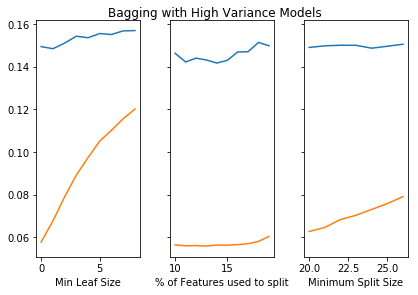

In [87]:
# Plot the data
fig, ax = plt.subplots(1,3, sharey='row')
fig.tight_layout(pad = 1.5)

ax[0].plot(df.iloc[0:9]['Root MSE'])
ax[0].plot(df.iloc[0:9]['Train MSE'])
ax[0].set_xlabel('Min Leaf Size')

ax[1].plot(df.iloc[10:20]['Root MSE'])
ax[1].plot(df.iloc[10:20]['Train MSE'])
ax[1].set_xlabel('% of Features used to split')

ax[2].plot(df.iloc[20:30]['Root MSE'])
ax[2].plot(df.iloc[20:30]['Train MSE'])
ax[2].set_xlabel('Minimum Split Size')

fig.suptitle('Bagging with High Variance Models')
# !!! remove the axis tick marks

### Boosting Illustration

In contrast, boosting is a process that reduces bias by refitting the model iteratively on the errors from the previous model. In effect, each model that passes through should be as simple as possible, since subsequent models will weight errors from the prior model more highly. We can see this phenomenon below

In [ ]:
# Initialize list of tests:
param_list = []

# Create list of parameter types
for depth in range(100):
    param_list.append({'max_depth': depth, 'n_estimators': 10})

In [ ]:
models_to_param_list = {GradientBoostingRegressor: param_list}

df_boosting = sf.try_different_models(cross_val_list, 
                             models_to_param_list,
                             outcome_vars, 
                             feature_sets)

In [ ]:
plt.scatter(df_boosting.index, df_boosting['Root MSE'])
plt.xlabel('Depth')
plt.ylabel('Error')

The random forest regressor shows up in the table as the DecisionTreeRegressor with the parentheses around the whole function. 

### Bias Variance Diagnosis

#### Random Forests
Using random forests, the training data substantially overfits relative to the test data when the complexity of the model is high. This means that most of the error at that point, although lower in absolute terms, is attributable to high variance. 

#### Gradient Boosting Regression Trees
Using Gradient boosting however, we find that the difference in the error between the training and test set is negligible when the model is simpler, suggesting that the underlying problem is a problem of bias. As the tree depth grows, the training set is overfit relative to the test set, and the underlying error stabilizes. 

#### Conclusion
Given that the random forests appear to have a lower absolute error, and given that the underlying problem is variance, not bias when the model is complex, we recommend several fixes to improve the model.

#### Recommendations to reduce variance
- Ensembling (within the model itself)
- Ensembling (with other models)
- Reduce the feature set


In [ ]:
plt.scatter(df.index, df['Root MSE'])
plt.scatter(df.index, df['Train MSE'])
plt.xlabel('Min Leaf Size')

In [ ]:
plt.scatter(df_boosting.index, df_boosting['Root MSE'])
plt.scatter(df_boosting.index, df_boosting['Train MSE'])
plt.xlabel('Tree Depth')

#### Where this modeling section is going

In our final report, we intend to include more sections of different typess of models and ensembles, and to build out the sections with some deeper explanations.

Some things we intend to try:
- Bayesian ridge models
- K nearest neighbor
- Boosting ensembles
- Bagging ensembles 

### Error Analysis

In this section, we'll go into more detail about how we actually iterated on models and chose whichever ones we end up deciding are our best. Our primary tools will be this error correlation table, which we'll use to look at patterns of errors the model is making, and diagnostics to determine whether or not the model is overfitting. We'll compare different models to each other and explain the model or ensemble that gives us the best results.

In [ ]:
lrdf

In [ ]:
# this still only works on individual models, it doens't average the correlations over a set of models
# this tool is really more exploratory than anything - look at a couple models from the set you care about
# and see what the trends are

# use this variable to specify which model specification to use
df_and_row_to_use = lrdf.iloc[0]
# use this variable to specify which in the list of models trained with that specification to use
model_to_use = df_and_row_to_use['Model'][1]
# don't change this
features_to_use = df_and_row_to_use['Features']

def create_error_correlation_table(model,
                                   outcome_var,
                                   feature_set,
                                   dev_df):
    
    '''
    finds correlation between absolute value of error
    and each feature
    '''
    
    final_data = {'col': feature_set}
    dev_df = dev_df.reset_index()
    
    dev_preds = model.predict(dev_df[feature_set])

    rmsles = []
    for i in range(len(dev_preds)):
        rmsles.append(sf.rmsle([dev_df[outcome_var][i]], [dev_preds[i]]))

    plt.clf()
    plt.hist(rmsles, bins=20)
    plt.xlabel("RMSLE")
    plt.ylabel("Number of Occurrences")
    plt.show()

    dev_df['linear_reg_errors'] = rmsles

    corrs = []
    for col in feature_set:
        try:
            cor = np.corrcoef(abs(dev_df['linear_reg_errors']), dev_df[col])[0,1]
            corrs.append(cor)
        except:
            pass

    final_data['correlation'] = corrs 
    
    corrs_df = pd.DataFrame(data=final_data)
    corrs_df = corrs_df.dropna()
    return corrs_df
  
# table for our LR with all the features
corrs_df = create_error_correlation_table(model_to_use, 'LogSalePrice', features_to_use, dev_df)
corrs_df.reindex(corrs_df.correlation.abs().sort_values(ascending=False).index)

### Plot Errors by Key Variables

#### Cycle through each model variation and plot errors

In [ ]:
# Creation of the error plot
import shared_functions as sf

In [ ]:
### Random Forest
df.sort_values('Root MSE', ascending=True).head(1)

In [ ]:
### Linear Regression
lrdf.sort_values('Root MSE', ascending=True).head(1)

In [ ]:
### Random Forest Errors
rf_error_spec = df.sort_values('Root MSE', ascending=True).iloc[0]
model_to_use = rf_error_spec['Model'][0]
features_to_use = rf_error_spec['Features']
plot_features = list(feature_importances[:20].index)
plot_error_against_var(model_to_use, 'LogSalePrice', features_to_use, plot_features, dev_df)

In [ ]:
### Linear Regression Errors
# use this variable to specify which model specification to use
df_and_row_to_use = lrdf.iloc[0]
model_to_use = df_and_row_to_use['Model'][0]
features_to_use = df_and_row_to_use['Features']
plot_features = list(feature_importances[:20].index)
plot_error_against_var(model_to_use, 'LogSalePrice', features_to_use, plot_features, dev_df)

# EMILY - YOUR SECTION